In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

### Validation ! Validation ! Validation !

In [26]:
from sklearn.datasets import load_digits

In [27]:
digits = load_digits()
X = digits.data
y = digits.target

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [29]:
y_pred = knn.predict(X)

In [31]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


### Validation Sets

Keeping data seperate for the learned models. 


In [32]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [33]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

441 / 450 correct


In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.97999999999999998

In [35]:
knn.score(X_test, y_test)

0.97999999999999998

In [36]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

(1, 0.97999999999999998)
(5, 0.98222222222222222)
(10, 0.97999999999999998)
(20, 0.97111111111111115)
(30, 0.95333333333333337)


## Cross-Validation

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice.
This is just one specialization of $K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.

In [37]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

0.97614938602520218

## Bias vs Variance Tradeoff

In [38]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

In [39]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

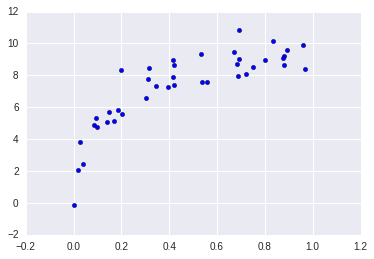

In [40]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

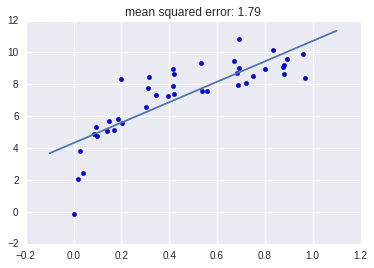

In [41]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

Underfits or is biased!


In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

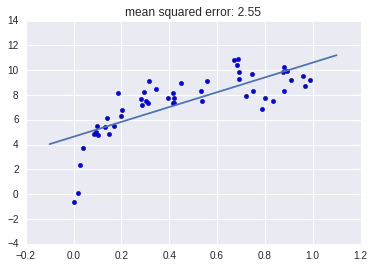

In [43]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

### Detecting Over-fitting with Validation Curves

Clearly, computing the error on the training data is not enough (we saw this previously). As above, we can use **cross-validation** to get a better handle on how the model fit is working.

Let's do this here, again using the ``validation_curve`` utility. To make things more clear, we'll use a slightly larger dataset:

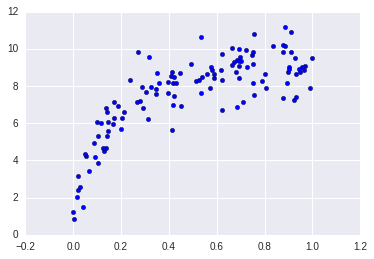

In [44]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [45]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

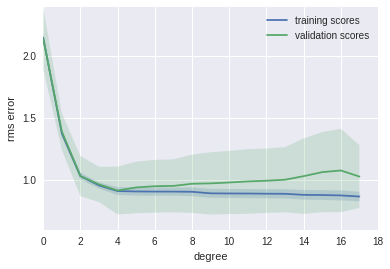

In [46]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Notice the trend here, which is common for this type of plot.

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

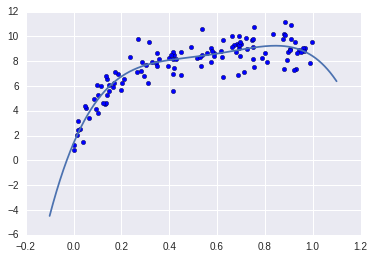

In [48]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### Detecting Data Sufficiency with Learning Curves

As you might guess, the exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

In [49]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

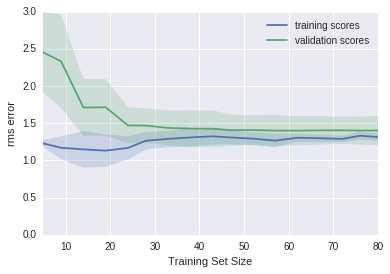

In [50]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *never* get you there.  For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

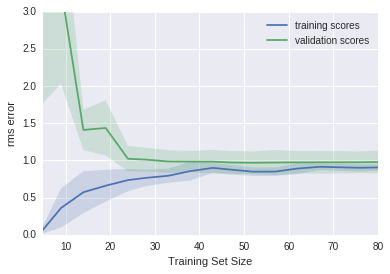

In [51]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

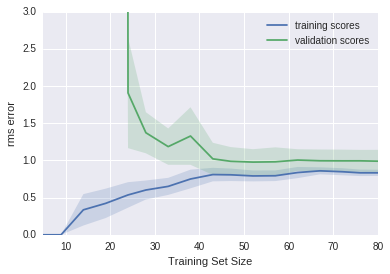

In [53]:
plot_learning_curve(10)

For an even more complex model, we still converge, but the convergence only happens for *large* amounts of training data.

So we see the following:

- you can **cause the lines to converge** by adding more points or by simplifying the model.
- you can **bring the convergence error down** only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model. If the curves are already close together, you need more model complexity. If the curves are far apart, you might also improve the model by adding more data.

To make this more concrete, imagine some telescope data in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question has real consequences, and can be addressed using these metrics.

## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.